In [755]:
import pandas
import seaborn
import matplotlib.pyplot as pyplot

seaborn.set_theme(style="darkgrid")

In [756]:
URGENCIAS_CSV_URL = "https://gitlab.com/mderr/data-science/-/raw/main/urgencias.csv"

In [757]:
IGNORED_COLUMN_NAMES = [ "consecutivo"      # Indice
                       , "servicio"         # Siempre URGENCIAS
                       , "cod_departamento" # Siempre 5
                       , "cod_municipio"    # Siempre 1
                       , "cod_eas"          # Estoy usando el nombre
                       , "cod_ips"          # Estoy usando el nombre
                       , "tipo_usuario"     # No se que es
                       , "causa_externa"    # No se que es
                       , "cod_dx_salida" ]

In [758]:
PIE_CHART_PALETTE = seaborn.color_palette('pastel')#[0:5]
pyplot.rcParams['figure.figsize'] = (18, 7)

In [759]:
def drop_columns( dataframe, column_names ):
    for column_name in column_names:
        dataframe = dataframe.drop(column_name, axis=1)

    return dataframe

def get_value_counts_dataframe( field_name, dataframe, dataframe_columns, sort_by_values=False ):
    data_dict = {}

    value_counts = dataframe.loc[:, field_name].value_counts()

    for index, key in  enumerate( value_counts.keys() ):
        data_dict[index] = [ key, value_counts[key] ]

    counts_dataframe = pandas.DataFrame.from_dict(data_dict, orient="index", columns=dataframe_columns)

    if sort_by_values:
        counts_dataframe = counts_dataframe.sort_values( counts_dataframe.keys()[-1], ascending=False )

    return counts_dataframe

def get_explode_array( array, explode_value=0.1 ):
    explode_array = [0] * len(array)
    explode_array[0] = explode_value

    return explode_array

def get_pct( value ):
    if value > 1.2:
        return "{}%".format( round(value, 1) )

def plot_pie_chart( counts_dataframe, plot_title, pctdistance=1.15, legend_fontsize=None ):
    labels_key = counts_dataframe.keys()[0]
    counts_key = counts_dataframe.keys()[1]

    explode_array = get_explode_array(counts_dataframe[counts_key])
    labels = [ label[:82] + "..." if len(label) > 82 else label for label in counts_dataframe[labels_key][:24] ]

    pyplot.title(plot_title, y=1.02, loc="left", fontdict={"fontsize": 30, "fontweight": "normal"})
    pyplot.pie(counts_dataframe[counts_key], startangle=90, colors=PIE_CHART_PALETTE, autopct=get_pct, pctdistance=pctdistance, explode=explode_array, shadow=True, counterclock=False)
    pyplot.legend(labels=labels, bbox_to_anchor=(1, 1), fontsize=legend_fontsize)

def age_to_integer( value ):
    if type(value) == str and value[-1] == " ":
        while value[-1] == " ":
            value = value[:-1]
        
    return int(value)

def week_to_years( weeks ):
    return weeks / 52.14285714

def days_to_years( days ):
    return days / 365

In [760]:
dataframe = pandas.read_csv(URGENCIAS_CSV_URL, sep=";")

dataframe.columns = [ column_name.split(".")[1] for column_name in dataframe.columns ]
dataframe = drop_columns(dataframe, IGNORED_COLUMN_NAMES)

dataframe

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


año  ... total_atenciones
0        2017  ...              1.0
1        2017  ...              1.0
2        2017  ...              1.0
3        2017  ...              1.0
4        2017  ...              1.0
...       ...  ...              ...
1725238  2016  ...              1.0
1725239  2016  ...              4.0
1725240  2016  ...              1.0
1725241  2016  ...              1.0
1725242  2016  ...              1.0

[1725243 rows x 9 columns]

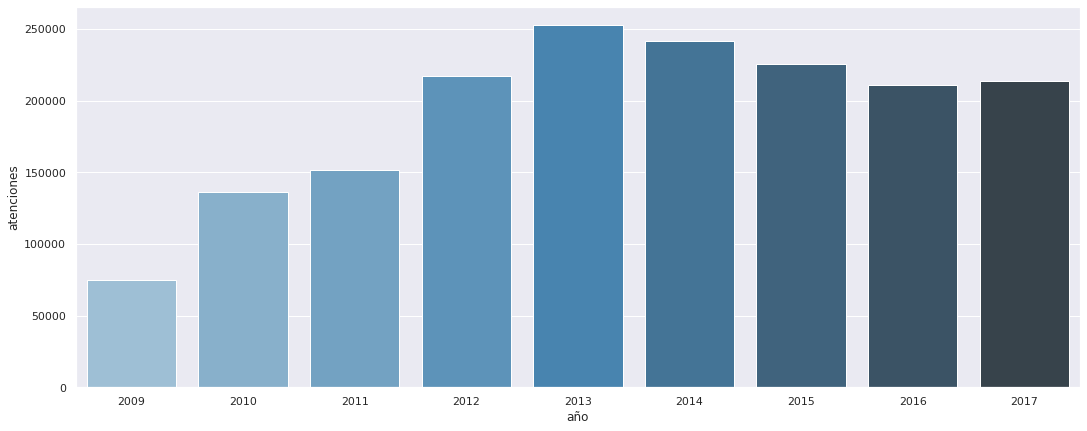

In [761]:
year_dataframe = get_value_counts_dataframe("año", dataframe, ["año", "atenciones"])

seaborn.barplot(data=year_dataframe, x="año", y="atenciones", palette="Blues_d")

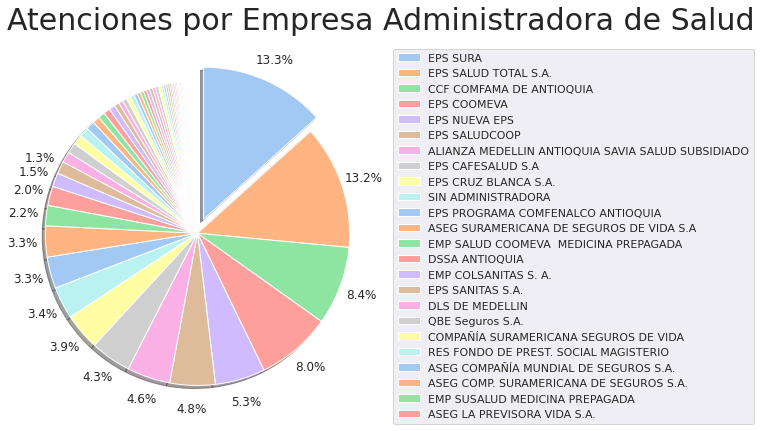

In [762]:
eases_dataframe = get_value_counts_dataframe("nombre_eas", dataframe, ["eas", "atenciones"], sort_by_values=True)

plot_pie_chart(eases_dataframe, "Atenciones por Empresa Administradora de Salud")
pyplot.show()

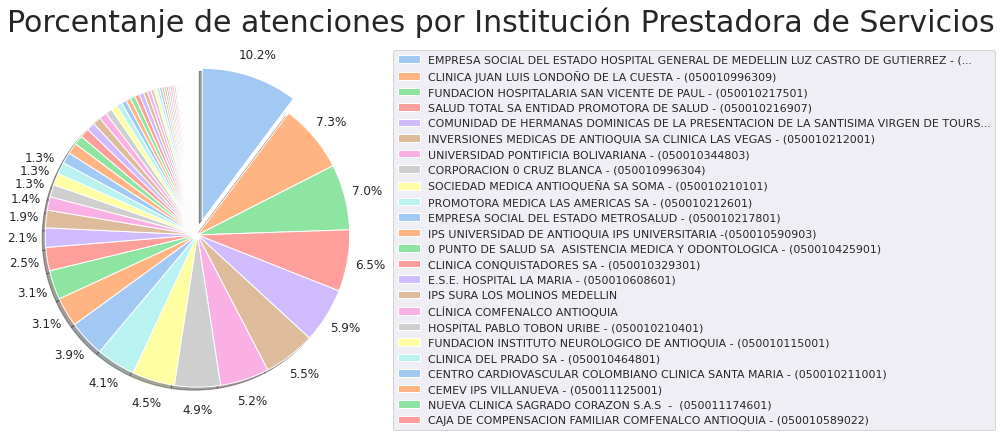

In [763]:
ipses_dataframe = get_value_counts_dataframe("nombre_institucion", dataframe, ["ips", "atenciones"], sort_by_values=True)

plot_pie_chart(ipses_dataframe, "Porcentanje de atenciones por Institución Prestadora de Servicios")
pyplot.show()

¿Qué es sexo M?

- H == Hombre (Casos relacionanos con la prostata)
- F == Mujer  (Casos relacionados con el utero)
- M == ?????? (Casos de ambos!?)


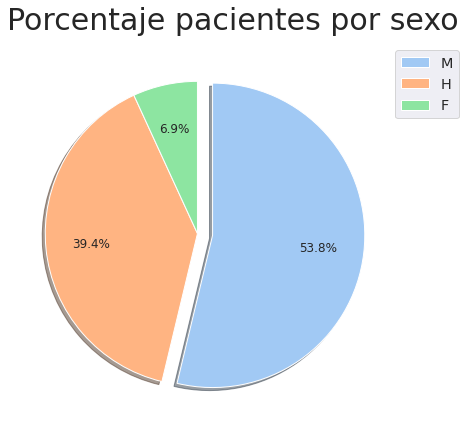

In [764]:
gender_dataframe = get_value_counts_dataframe("sexo", dataframe, ["sexo", "pacientes"], sort_by_values=True)

plot_pie_chart(gender_dataframe, "Porcentaje pacientes por sexo", pctdistance=0.7, legend_fontsize="large")
pyplot.show()

In [765]:
dataframe.loc[dataframe.edad == "   ", "edad"] = 0  # El que escribio "   " no tiene mamá
dataframe.loc[dataframe.edad == 261, "edad"]   = 61 # La persona mas vieja del mundo tiene 122, entonces 16 o 61?

dataframe["edad"] = dataframe["edad"].agg(age_to_integer)

# Tipo de edad: 0 == Ni idea, 1 == Años?, 2 == Semanas?, 3 == Dias?
dataframe.loc[dataframe["tipo_edad"] == 2, "edad"] = dataframe[dataframe["tipo_edad"] == 2]["edad"].apply(week_to_years)
dataframe.loc[dataframe["tipo_edad"] == 3, "edad"] = dataframe[dataframe["tipo_edad"] == 2]["edad"].apply(days_to_years)

In [766]:
age_groups_labels = ["Infantes", "Adolecentes", "Adultos", "Ancianos"]
age_groups = pandas.DataFrame( pandas.cut(dataframe["edad"], bins=[0, 12, 18, 60, 118], labels=age_groups_labels) ) # Bins basadas en categorias de las encuestas del min salud (https://www.minsalud.gov.co/sites/rid/Lists/BibliotecaDigital/RIDE/VS/ED/GCFI/portafolio-presentaciones-gcfi-estudios-poblacionales.pdf, pg. 36)

age_dataframe = get_value_counts_dataframe("edad", age_groups, ["grupo", "pacientes"], sort_by_values=True)

plot_pie_chart(age_dataframe, "Porcentaje de atenciones por edad", pctdistance=0.7, legend_fontsize="large")
pyplot.show()

In [767]:
reasons_count = len(set(dataframe["nombre_dx"]))
reasons_mode = dataframe["nombre_dx"].mode()[0]
reasons_mode_count = dataframe[dataframe["nombre_dx"] == reasons_mode]["nombre_dx"].value_counts()[0]

age_mean = dataframe["edad"].mean()
age_mode = dataframe["edad"].mode()[0]
age_mode_count = len(dataframe[dataframe["edad"] == age_mode])

eas_count = len(set(dataframe["nombre_eas"]))
ips_count = len(set(dataframe["nombre_institucion"]))

print("- Hay un total de {} razónes diferentes por las cuales se han presentado pacientes a urgencias, la más común de estas es la de '{}' con {} casos reportados".format(reasons_count, reasons_mode, reasons_mode_count))
print("- El promedio de edad de las personas ingresadas a urgencias es de {} años, mientras que la edad más común es de {} años, con un total de {} pacientes de esta edad.".format( round(age_mean, 1), round(age_mode), age_mode_count ))
print("- Hay un total de {} Entidades Administradoras de Salud que atienden a sus afiliados por medio de {} Instituciones Prestadoras de Servicios.".format(eas_count, ips_count))

- Hay un total de 8588 razónes diferentes por las cuales se han presentado pacientes a urgencias, la más común de estas es la de 'OTROS DOLORES ABDOMINALES Y LOS NO ESPECIFICADOS' con 41085 casos reportados
- El promedio de edad de las personas ingresadas a urgencias es de 36.4 años, mientras que la edad más común es de 23 años, con un total de 37345 pacientes de esta edad.
- Hay un total de 244 Entidades Administradoras de Salud que atienden a sus afiliados por medio de 325 Instituciones Prestadoras de Servicios.
